In [5]:
import os
from google.colab import drive
drive.mount("/content/gdrive")

os.chdir('/content/gdrive/My Drive')
print("Current working directory:", os.getcwd())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Current working directory: /content/gdrive/My Drive


I. Kernel Eigenfaces

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load Yale Face Database
def load_yale_face_database(dataset_path):
    images = []  # List to store images
    labels = []  # List to store corresponding labels
    for file_name in os.listdir(dataset_path):
        if file_name.endswith(".pgm"):  # Yale Face Database images are usually in .pgm format
            image = cv2.imread(os.path.join(dataset_path, file_name), cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            image_resized = cv2.resize(image, (64, 64))  # Resize image to a consistent size (64x64)
            images.append(image_resized)
            label = int(file_name.split(".")[0][-2:])  # Assuming file name format includes person ID (e.g., "subject01")
            labels.append(label)
    return np.array(images), np.array(labels)  # Return images and labels as numpy arrays

# Dataset path for training and testing
train_dataset_path = "/content/gdrive/My Drive/Yale_Face_Database/Training"  # Replace with your dataset folder path
test_dataset_path = "/content/gdrive/My Drive/Yale_Face_Database/Testing"  # Replace with your dataset folder path

# Load training data
images, labels = load_yale_face_database(train_dataset_path)

# Flatten the images for PCA and LDA
images_flattened = images.reshape(len(images), -1)

# PCA (Principal Component Analysis)
def PCA(data, n_components):
    # 1. Center the data by subtracting the mean
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    # 2. Compute the covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)
    # 3. Perform Eigen decomposition (Eigenvalue and Eigenvector calculation)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # 4. Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort eigenvalues in descending order
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # 5. Select the top n_components eigenvectors
    W = eigenvectors[:, :n_components]
    # 6. Project the data into the new space spanned by the eigenvectors
    reduced_data = np.dot(centered_data, W)

    return reduced_data, W, mean  # Return reduced data, eigenvectors, and mean image

# LDA (Linear Discriminant Analysis)
def LDA(data, labels, n_components):
    # 1. Compute the total mean of the data
    mean_total = np.mean(data, axis=0)
    # 2. Compute class-wise means and within-class scatter matrix
    class_labels = np.unique(labels)  # Unique class labels
    mean_per_class = {}
    S_W = np.zeros((data.shape[1], data.shape[1]))  # Within-class scatter matrix
    S_B = np.zeros((data.shape[1], data.shape[1]))  # Between-class scatter matrix
    for label in class_labels:
        class_data = data[labels == label]  # Get data for the current class
        mean_class = np.mean(class_data, axis=0)  # Compute class mean
        mean_per_class[label] = mean_class
        N_i = class_data.shape[0]  # Number of samples in the class
        # Within-class scatter matrix
        centered_data = class_data - mean_class
        S_W += np.dot(centered_data.T, centered_data)
        # Between-class scatter matrix
        mean_diff = (mean_class - mean_total).reshape(-1, 1)
        S_B += N_i * np.dot(mean_diff, mean_diff.T)
    # 3. Compute eigenvalues and eigenvectors of the matrix inv(S_W) * S_B
    eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(S_W).dot(S_B))
    # 4. Sort eigenvalues in descending order and select the top n_components eigenvectors
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]
    # 5. Select the top n_components eigenvectors
    W = eigvecs[:, :n_components]
    # 6. Project the data into the new space spanned by the LDA components
    projected_data = np.dot(data, W)

    return W, mean_total  # Return the LDA transformation matrix and total mean

# Function to plot eigenfaces
def eigen_plot(n_components, eigenvectors):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Create a grid of subplots for 25 eigenfaces
    for i, ax in enumerate(axes.flat):
        eigenface = eigenvectors[:, i].reshape(64, 64)  # Reshape the eigenvector to a 64x64 image
        ax.imshow(eigenface, cmap='gray')  # Display the eigenface in grayscale
        ax.axis('off')  # Turn off axis
    plt.suptitle("Top 25 Eigenfaces")  # Title for the plot
    plt.show()  # Display the plot

# Function to display 10 random images (original and reconstructed)
def radom_show_10_image(images, reconstructed_images):
    random_indices = np.random.choice(len(images), 10, replace=False)  # Randomly select 10 images
    fig, axes = plt.subplots(10, 2, figsize=(8, 20))  # Create subplots for original and reconstructed images
    for i, idx in enumerate(random_indices):
        axes[i, 0].imshow(images[idx], cmap='gray')  # Display original image
        axes[i, 0].set_title("Original")  # Title for original image
        axes[i, 1].imshow(reconstructed_images[idx].reshape(64, 64), cmap='gray')  # Display reconstructed image
        axes[i, 1].set_title("Reconstructed")  # Title for reconstructed image
        for ax in axes[i]:
            ax.axis("off")  # Turn off axis for both images
    plt.show()  # Display the images


Part 1

PCA

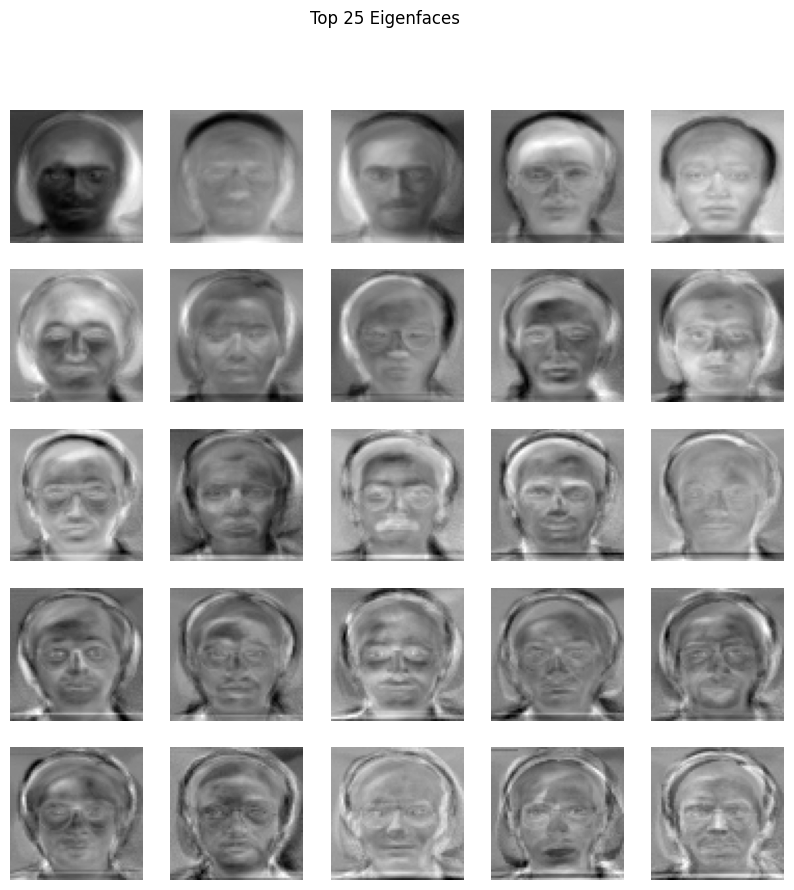

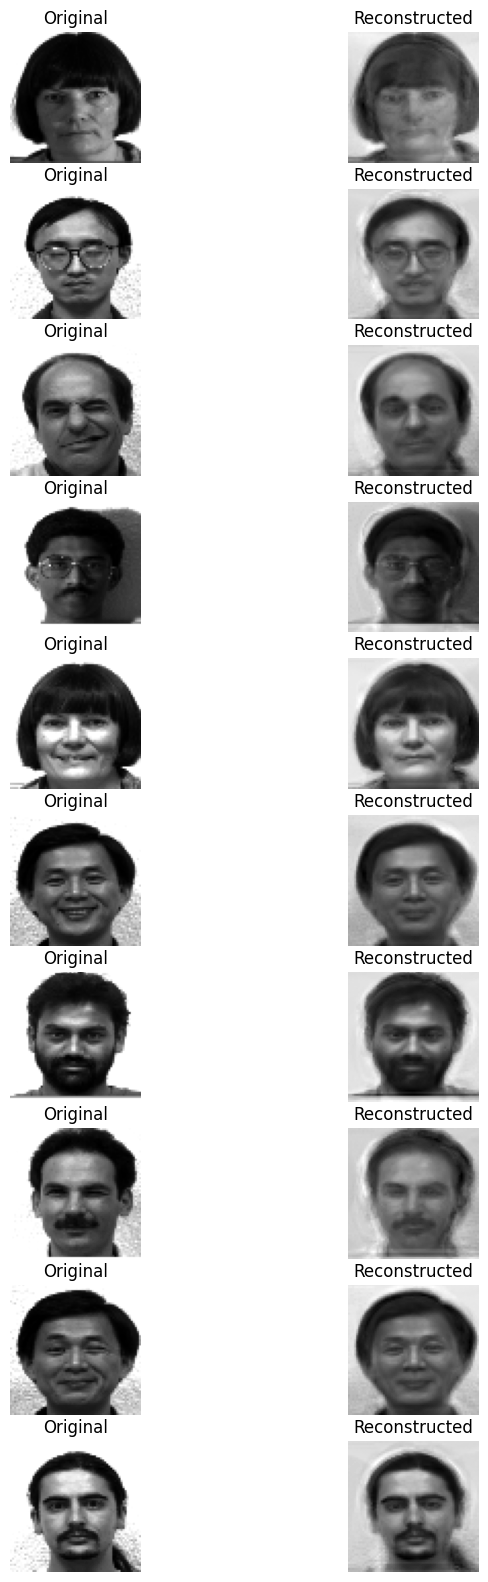

In [7]:
# Use PCA for dimensionality reduction
n_components = 25  # Set the number of principal components to 25
reduced_data, W, mean_image = PCA(images_flattened, n_components)  # Apply PCA to the flattened images

# Visualize eigenfaces (principal components)
eigen_plot(25, W)  # Plot the first 25 eigenfaces (principal components)

# Reconstruct images using the PCA feature vectors
# Reconstruct images by projecting the reduced data back to the original space
reconstructed_images = reduced_data @ W.T + mean_image  # Reconstruct the images using the eigenvectors

# Display 10 randomly selected original and reconstructed images
radom_show_10_image(images, reconstructed_images)  # Compare the original images with the reconstructed ones


LDA

In [ ]:
# LDA dimensionality reduction to 25 dimensions
lda_vectors, mean_total = LDA(images_flattened, labels, n_components)

# LDA eigenvectors (feature vectors)
eigen_plot(25, lda_vectors)  # Visualize the first 25 LDA eigenvectors

# Reconstruct images using LDA feature vectors
# First, project the original image data onto the LDA feature space

projected_images = ((images_flattened - mean_total) @ lda_vectors)  # Project images onto LDA space
reconstructed_images = (projected_images @ lda_vectors.T) + mean_total  # Reconstruct images from the LDA space

# Display 10 randomly selected images: original and reconstructed
radom_show_10_image(images, reconstructed_images)


Part 2. Face recognition

In [ ]:
# KNN Classifier
def knn_classifier(train_data, train_labels, test_data, k):
    predictions = []  # List to store the predicted labels for each test sample
    for test_sample in test_data:
        # Compute the Euclidean distance between the test sample and each training sample
        distances = [np.linalg.norm(test_sample - train_sample) for train_sample in train_data]

        # Get the indices of the k closest training samples
        k_indices = np.argsort(distances)[:k]

        # Retrieve the labels of the k nearest neighbors
        k_labels = train_labels.take(k_indices)  # 'take' function is used for performance enhancement

        # Perform a majority vote to decide the predicted label
        unique, counts = np.unique(k_labels, return_counts=True)
        predictions.append(unique[np.argmax(counts)])  # Append the label with the most votes

    return np.array(predictions)  # Return the predictions as a numpy array


# Accuracy Calculation
def compute_accuracy(true_labels, predicted_labels):
    return np.mean(true_labels == predicted_labels)  # Compute the fraction of correct predictions


# Main Program
def face_recognition_with_pca_and_lda(X_train, y_train, X_test, y_test, n_components, k_neighbors_list):
    # PCA
    X_train_pca, pca_components, pca_mean = PCA(X_train, n_components)  # Apply PCA on training data
    X_test_pca = np.dot(X_test - pca_mean, pca_components)  # Apply the same transformation to the test data

    # Classification using PCA for each k
    print("PCA Results:")
    for k in k_neighbors_list:
        pca_predictions = knn_classifier(X_train_pca, y_train, X_test_pca, k)  # Perform KNN classification with PCA-transformed data
        pca_accuracy = compute_accuracy(y_test, pca_predictions)  # Calculate accuracy
        print(f"k={k}, PCA Accuracy: {pca_accuracy:.4f}")

    # LDA
    lda_components, lda_mean = LDA(X_train, y_train, n_components)  # Apply LDA on training data
    X_train_lda = np.dot(X_train, lda_components)  # Transform the training data using LDA components
    X_test_lda = np.dot(X_test, lda_components)  # Transform the test data using LDA components

    # Classification using LDA for each k
    print("\nLDA Results:")
    for k in k_neighbors_list:
        lda_predictions = knn_classifier(X_train_lda, y_train, X_test_lda, k)  # Perform KNN classification with LDA-transformed data
        lda_accuracy = compute_accuracy(y_test, lda_predictions)  # Calculate accuracy
        print(f"k={k}, LDA Accuracy: {lda_accuracy:.4f}")


# Load data (assuming you have a function `load_yale_face_database` to load the dataset)
X_train, y_train, X_test, y_test = load_yale_face_database(train_dataset_path)[0], load_yale_face_database(train_dataset_path)[1], load_yale_face_database(test_dataset_path)[0], load_yale_face_database(test_dataset_path)[1]

# Reshape the training and testing data (flatten the images)
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

# Number of components for PCA and LDA
n_components = 25
# List of k values to test for KNN
K = [1, 3, 5, 7, 9, 11]

# Run the face recognition with PCA and LDA
face_recognition_with_pca_and_lda(X_train, y_train, X_test, y_test, n_components, K)


Part 3

In [ ]:
def kernel_matrix(X, Y, kernel, gamma=1e-10):
    X_mean = np.mean(X, axis=0)  # Compute the mean of each feature
    X_centered = X - X_mean

    Y_mean = np.mean(Y, axis=0)  # Compute the mean of each feature
    Y_centered = Y - Y_mean

    if kernel == 1:
        K = X_centered @ Y_centered.T
    elif kernel == 2:
        K = (X_centered @ Y_centered.T + 1)**3
    elif kernel == 3:
        sq_dists = np.sum(X_centered**2, axis=1).reshape(-1, 1) + np.sum(Y_centered**2, axis=1) - 2 * X_centered @ Y_centered.T
        K = np.exp(-gamma * sq_dists)
    else:
        raise ValueError("Kernel not recognized!")
    return K

def kernelPCA(X, dims, kernel_type):
    # Step 1: Center the input data
    X_mean = np.mean(X, axis=0)  # Compute the mean of each feature
    X_centered = X - X_mean      # Center the data by subtracting the mean

    # Step 2: Compute the kernel matrix
    kernel = kernel_matrix(X_centered, X_centered, kernel=kernel_type)  # Use linear kernel

    # Step 3: Center the kernel matrix
    n = kernel.shape[0]
    one = np.ones((n, n), dtype=np.float64) / n  # Create a matrix of ones normalized by n
    kernel = kernel - one @ kernel - kernel @ one + one @ kernel @ one

    # Step 4: Perform eigenvalue decomposition
    eigen_val, eigen_vec = np.linalg.eigh(kernel)

    # Step 5: Normalize eigenvectors
    for i in range(eigen_vec.shape[1]):
        eigen_vec[:, i] = eigen_vec[:, i] / np.linalg.norm(eigen_vec[:, i])

    # Step 6: Select the top 'dims' eigenvectors (principal components)
    idx = np.argsort(eigen_val)[::-1]  # Sort eigenvalues in descending order
    W = eigen_vec[:, idx][:, :dims].real  # Select the top 'dims' eigenvectors

    return W

# Kernel LDA (Linear Discriminant Analysis) implementation
def kernelLDA(X, label, dims, kernel_type):
    # Step 1: Center the input data
    X_mean = np.mean(X, axis=0)  # Compute the mean of each feature
    X_centered = X - X_mean      # Center the data by subtracting the mean
    label = np.asarray(label)
    c = np.unique(label)  # Get unique classes

    kernel = kernel_matrix(X_centered, X_centered, kernel=kernel_type)  # Use linear kernel

    # Step 3: Calculate within-class scatter matrix (N) and between-class scatter matrix (M)
    n = kernel.shape[0]
    mu = np.mean(kernel, axis=0)  # Mean of the kernel matrix
    N = np.zeros((n, n), dtype=np.float64)  # Within-class scatter matrix
    M = np.zeros((n, n), dtype=np.float64)  # Between-class scatter matrix

    for i in c:
        K_i = kernel[np.where(label == i)[0], :]  # Submatrix for class i
        l = K_i.shape[0]  # Number of samples in class i
        mu_i = np.mean(K_i, axis=0)  # Mean of class i
        N += K_i.T @ (np.eye(l) - (np.ones((l, l), dtype=np.float64) / l)) @ K_i  # Compute within-class scatter
        M += l * ((mu_i - mu).T @ (mu_i - mu))  # Compute between-class scatter

    # Step 4: Compute the eigenvalues and eigenvectors
    eigen_val, eigen_vec = np.linalg.eig(np.linalg.pinv(N) @ M)

    # Step 5: Normalize eigenvectors
    for i in range(eigen_vec.shape[1]):
        eigen_vec[:, i] = eigen_vec[:, i] / np.linalg.norm(eigen_vec[:, i])

    # Step 6: Sort eigenvalues and select top 'dims' eigenvectors
    idx = np.argsort(eigen_val)[::-1]  # Sort eigenvalues in descending order
    W = eigen_vec[:, idx][:, :dims].real  # Select top 'dims' eigenvectors

    return W

def face_recognition_with_ker_pca_and_ker_lda(X_train, y_train, X_test, y_test, k_neighbors, kernel_type):
    kernels = ['linear', 'polynomial', 'rbf']  # Available kernel types

    # Compute kernel matrix for test data based on the training data
    K = kernel_matrix(X_train, X_test, kernel_type, gamma=1e-10)

    # Perform Kernel PCA on the training data
    W = kernelPCA(X_train, 25, kernel_type)

    # Compute kernel matrix for training data
    K_train = kernel_matrix(X_train, X_train, kernel_type, gamma=1e-10)

    # Map training and test data to the new feature space
    new_train = K_train.T @ W  # Transform training data
    new_test = K.T @ W     # Transform test data

    # Print accuracy for each k in k_neighbors
    print('PCA Accuracy with kernel:', kernels[kernel_type - 1])
    for k in k_neighbors:
        predictions = knn_classifier(new_train, y_train, new_test, k)  # Perform k-NN classification
        pca_accuracy = compute_accuracy(y_test, predictions)  # Compute classification accuracy
        print(f"(k={k}) Accuracy: {pca_accuracy:.4f} ")
    print()
    # Compute kernel matrix for test data based on the training data
    K = kernel_matrix(X_train, X_test, kernel_type, gamma=1e-10)

    # Perform Kernel PCA on the training data
    W = kernelLDA(X_train, y_train, 25, kernel_type)

    # Compute kernel matrix for training data
    K_train = kernel_matrix(X_train, X_train, kernel_type, gamma=1e-10)

    # Map training and test data to the new feature space
    new_train = K_train.T @ W  # Transform training data
    new_test = K.T @ W     # Transform test data

    # Print accuracy for each k in k_neighbors
    print('LDA Accuracy with kernel:', kernels[kernel_type - 1])
    for k in k_neighbors:
        predictions = knn_classifier(new_train, y_train, new_test, k)  # Perform k-NN classification
        pca_accuracy = compute_accuracy(y_test, predictions)  # Compute classification accuracy
        print(f"(k={k}) Accuracy: {pca_accuracy:.4f} ")
    print()



K = [1, 3, 5, 7, 9, 11]

for kernel_type in range(1,4):
  face_recognition_with_ker_pca_and_ker_lda(X_train, y_train, X_test, y_test, K, kernel_type)


II. t-SNE

In [ ]:
os.chdir('/content/gdrive/My Drive')

In [ ]:
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display

# Function to generate a GIF from a series of snapshots during iterations
def generat_gif(Y_history, method):
    filenames = []
    # Loop through the snapshots and generate scatter plots for each iteration
    for i, Y_snapshot in enumerate(Y_history):
        plt.figure(figsize=(8, 8))
        plt.scatter(Y_snapshot[:, 0], Y_snapshot[:, 1], c=labels, cmap='jet', s=5)  # Scatter plot of 2D points
        plt.colorbar()  # Add a color bar to show the labels
        plt.title(f"Iteration {i * 10}")  # Title to indicate the iteration
        filename = f"frame_{i}.png"  # Save the figure as a PNG file
        plt.savefig(filename)  # Save the plot as a file
        filenames.append(filename)  # Add filename to the list of frames
        plt.close()  # Close the plot to free memory

    # Combine the saved PNG frames into a GIF file
    gif_filename = f"{method}.gif"  # Use the method name to name the GIF
    with imageio.get_writer(gif_filename, mode="I", duration=0.2) as writer:
        for filename in filenames:
            image = imageio.imread(filename)  # Read the saved frame
            writer.append_data(image)  # Add the frame to the GIF

    # Optionally remove the temporary PNG frames
    for filename in filenames:
        os.remove(filename)

    print(f"GIF has been created and saved as '{gif_filename}'.")  # Print confirmation message


# Function to visualize and compare similarity distributions in high-dimensional and low-dimensional spaces
def visualize_similarity_distributions(P, Q, method_name):
    """
    Compare the similarity distributions in high-dimensional and low-dimensional spaces on the same graph.
    """
    # Extract non-diagonal elements from the similarity matrices
    P_vals = P[np.triu_indices_from(P, k=1)]  # High-dimensional similarities (upper triangle of matrix P)
    Q_vals = Q[np.triu_indices_from(Q, k=1)]  # Low-dimensional similarities (upper triangle of matrix Q)

    # Create a new figure for the plot
    plt.figure(figsize=(8, 6))

    # Use Kernel Density Estimation (KDE) to smooth the similarity distributions
    sns.kdeplot(P_vals, color='blue', label='High-Dimensional Similarity (P)', linewidth=2)
    sns.kdeplot(Q_vals, color='green', label='Low-Dimensional Similarity (Q)', linewidth=2)

    # Set the plot title and labels
    plt.title(f"Comparison of Similarity Distributions - {method_name}", fontsize=14)
    plt.xlabel("Similarity Value", fontsize=12)
    plt.ylabel("Density(log)", fontsize=12)
    plt.legend(fontsize=12)  # Add a legend to distinguish the distributions
    plt.grid(True, linestyle='--', alpha=0.7)  # Add a grid to the plot

    # Display the plot
    plt.show()


Run Y = sym_sne(X, no_dims, perplexity) to perform sym-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 3.194475
Iteration 101: error is 2.265889


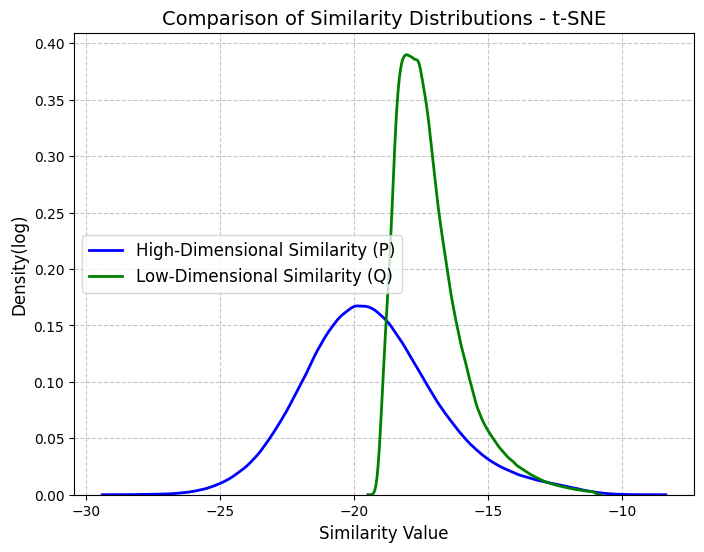

<ipython-input-42-bee6825479c5>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)  # Read the saved frame


GIF has been created and saved as 't-SNE.gif'.
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 3.194475


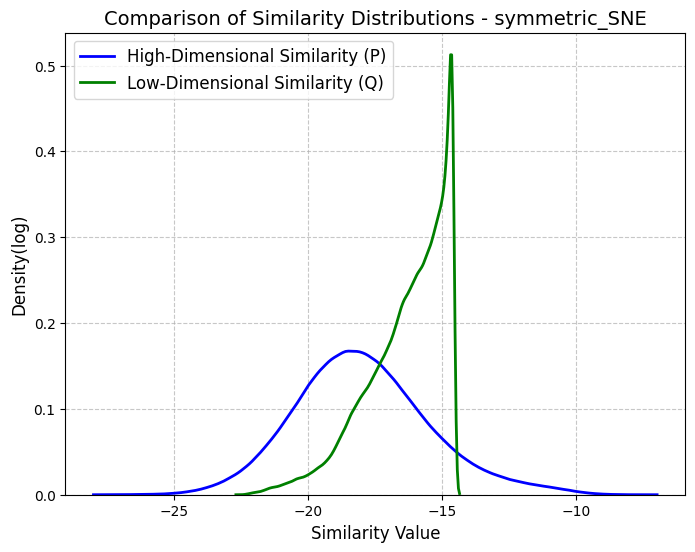

<ipython-input-42-bee6825479c5>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)  # Read the saved frame


GIF has been created and saved as 'symmetric_SNE.gif'.


In [ ]:
import numpy as np
import pylab
import seaborn as sns

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1
    Y_history = []
    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 300
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            Y_history.append(Y.copy())

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))
    # Return solution
    return Y, Y_history, P, Q

def sym_sne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1
    Y_history = []
    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 100
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise Gaussian affinities in low-dimensional space
        sum_Y = np.sum(np.square(Y), 1)
        D_low = np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y)
        Q = np.exp(-D_low)
        Q[range(n), range(n)] = 0.  # no self-loops
        Q = Q / np.sum(Q)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
          dY[i, :] = np.sum(np.tile(PQ[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)


        # Perform the update
        if iter < 20:
          momentum = initial_momentum
        else:
          momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            Y_history.append(Y.copy())

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

    # Return solution
    return Y, Y_history, P, Q

if __name__ == "__main__":
    print("Run Y = sym_sne(X, no_dims, perplexity) to perform sym-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X = np.loadtxt("mnist2500_X.txt")
    labels = np.loadtxt("mnist2500_labels.txt")

    # 執行 sym_sne 並取得歷史記錄
    Y, Y_history, P, Q = tsne(X, 2, 50, 100.0)
    visualize_similarity_distributions(np.log(P), np.log(Q), "t-SNE")
    generat_gif(Y_history ,"t-SNE")


    Y, Y_history, P, Q = sym_sne(X, 2, 50, 100.0)
    visualize_similarity_distributions(np.log(P), np.log(Q), "symmetric_SNE")
    generat_gif(Y_history ,"symmetric_SNE")

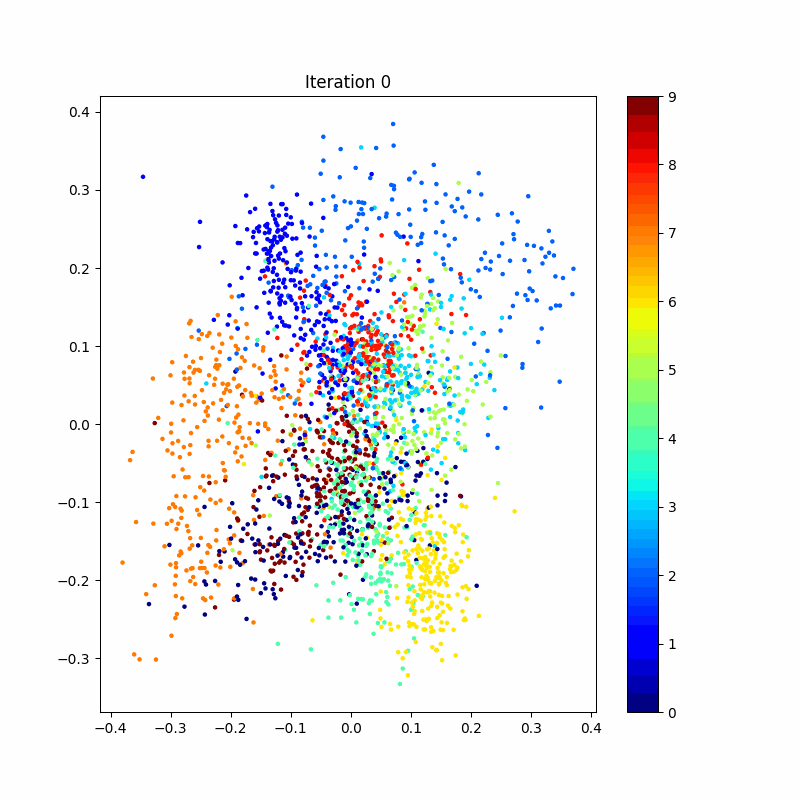

In [ ]:
display(Image(filename="t-SNE.gif"))

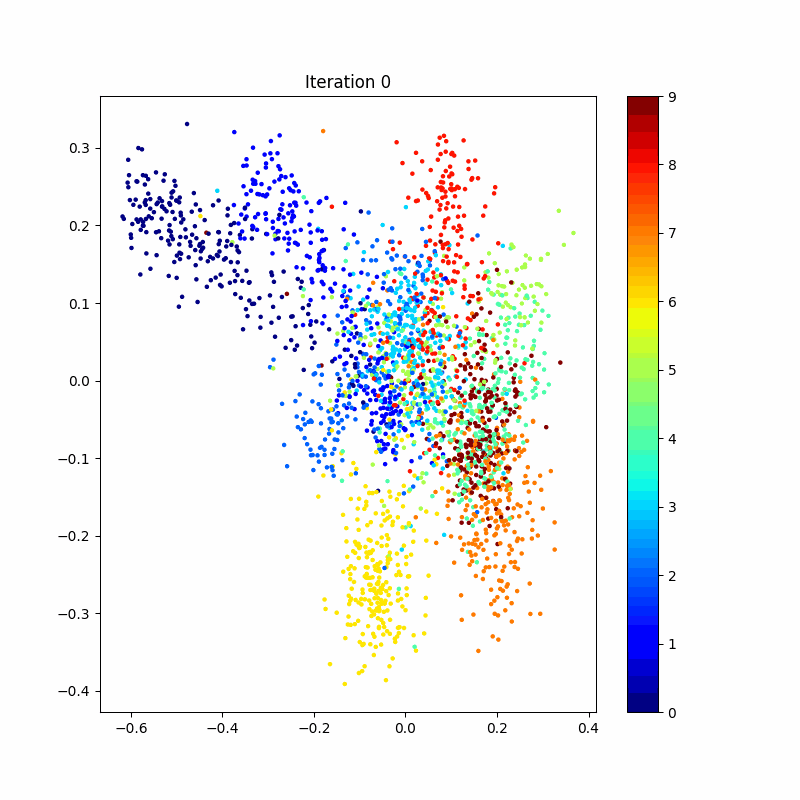

In [ ]:
display(Image(filename="symmetric_SNE.gif"))